<a href="https://colab.research.google.com/github/Serega1067/Learning_AB_testing/blob/main/ab_testing_homework9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Урок 9. Python применение продвинутых методов.

Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

Mobile Games AB Testing with Cookie Cats.

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import kstest

In [8]:
df = pd.read_csv('cookie_cats.csv')
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


In [10]:
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


In [11]:
df.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [12]:
df.nlargest(5, ['sum_gamerounds'])

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,0,1
7912,871500,gate_30,2961,1,1
29417,3271615,gate_40,2640,1,0
43671,4832608,gate_30,2438,1,1
48188,5346171,gate_40,2294,1,1


In [15]:
# Удаляем выброс
df = df[df.sum_gamerounds < 3000]
df.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018800e+04,90188.000000,90188.000000,90188.000000
mean,4.998397e+06,51.320253,0.445214,0.186056
std,2.883298e+06,102.682719,0.496992,0.389154
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512211e+06,5.000000,0.000000,0.000000
50%,4.995804e+06,16.000000,0.000000,0.000000
75%,7.496461e+06,51.000000,1.000000,0.000000
max,9.999861e+06,2961.000000,1.000000,1.000000


In [16]:
# Определим размеры выборок для проверки, что сравнение статистически обосновано.
# Сравним версии gate_30 и gate_40.
A = df.version.groupby(df.version == 'gate_30').count()
B = df.version.groupby(df.version == 'gate_40').count()
print(A)
print(B)

version
False    45489
True     44699
Name: version, dtype: int64
version
False    44699
True     45489
Name: version, dtype: int64


Число версий примерно одинаковы.  
Версия gate_30 - контрольная группа A.  
Версия gate_40 - тестовая группа B.

In [18]:
mannwhitneyu(df[df.version == 'gate_30'].sum_gamerounds,
             df[df.version == 'gate_40'].sum_gamerounds)

MannwhitneyuResult(statistic=1024285761.5, pvalue=0.05089155279145376)

p-value близко к 0.05, соответственно, этого теста не достаточно для принятия решения

In [23]:
ttest_ind(df[df.version == 'gate_30'].sum_gamerounds,
          df[df.version == 'gate_40'].sum_gamerounds)

Ttest_indResult(statistic=0.0633675766982082, pvalue=0.9494739458256001)

In [24]:

print(kstest(df['sum_gamerounds'][df.version == 'gate_30'], 'norm'))
print(kstest(df['sum_gamerounds'][df.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724153079945488, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Распределение не нормальное.

Text(0.5, 1.0, 'Number of game rounds players on the first week')

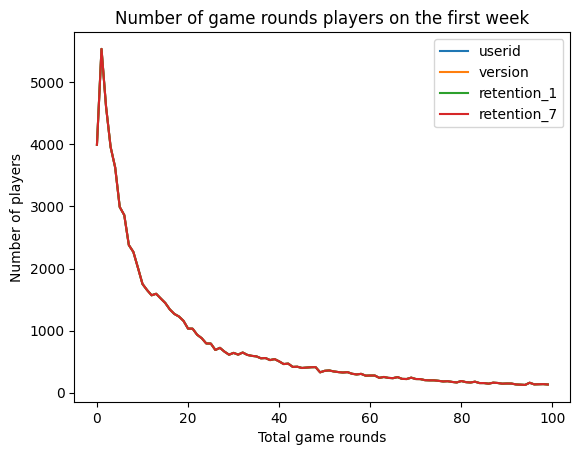

In [25]:
# Найдем сколько пользователь играет
plot_df = df.groupby('sum_gamerounds').count()

ax = plot_df[:100].plot()
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
ax.set_title('Number of game rounds players on the first week')

График показывает, что большинство пользователей играет менее 20 раундов.

Построим гистограммный график различных распределений групп AB.  
Чтобы получить более детальное представление о низкой и высокой активности пользователей изменим наше распределение выборок.

In [26]:
plt.style.use('ggplot')

Group_A = df[df.version == 'gate_30']
print(Group_A.head())

Group_B = df[df.version == 'gate_40']
print(Group_B.head())

bins = [0, 1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 500]
plot_GA = pd.DataFrame(Group_A.groupby(pd.cut(Group_A['sum_gamerounds'],
                                              bins=bins)).count())
plot_GB = pd.DataFrame(Group_B.groupby(pd.cut(Group_B['sum_gamerounds'],
                                              bins=bins)).count())

    userid  version  sum_gamerounds  retention_1  retention_7
0      116  gate_30               3            0            0
1      337  gate_30              38            1            0
6     1066  gate_30               0            0            0
11    2101  gate_30               0            0            0
13    2179  gate_30              39            1            0
   userid  version  sum_gamerounds  retention_1  retention_7
2     377  gate_40             165            1            0
3     483  gate_40               1            0            0
4     488  gate_40             179            1            1
5     540  gate_40             187            1            1
7    1444  gate_40               2            0            0


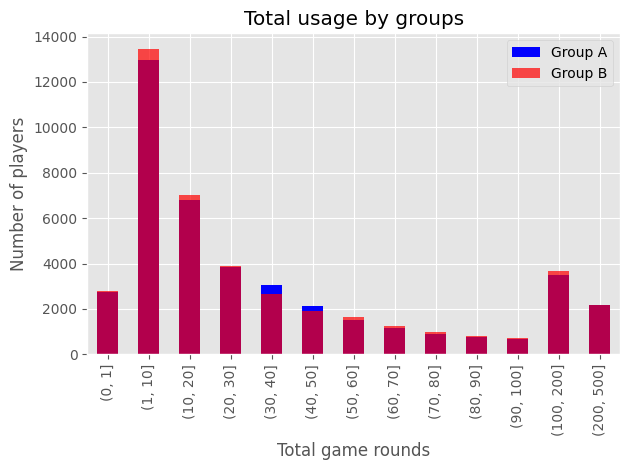

In [27]:
ax = plot_GA.plot(kind = 'bar', y='userid', color = 'blue', alpha = 1,
                  title = 'Total usage by groups')
plot_GB.plot(kind = 'bar', y = 'userid', ax = ax, color = 'red', alpha = 0.7)
ax.set_xlabel('Total game rounds')
ax.set_ylabel('Number of players')
plt.legend(['Group A', 'Group B'])
plt.tight_layout()
plt.grid(True)

Гафик показывает, что между двумя версиями нет большой разницы.  
Небольшие различия есть в пределах 30 - 40 сыгранных раундов.

Посмотрим какое удержание в течении 1 дня.

In [28]:
oneday = df.retention_1.sum()/df.retention_1.count()
print(str(oneday*100)+'%')

44.521444094558035%


Посмотрим какое удержание в течении 1 дня для групп.

In [29]:
oneday = df.retention_1.groupby(df.version).sum()/df.retention_1.groupby(df.version).count()
print(oneday*100)

version
gate_30    44.819795
gate_40    44.228275
Name: retention_1, dtype: float64


Обе версии имеют практически одинаковые результаты.  
Четкого ответа стоит ли применять изменение мы не получили.  
Для принятия решения воспользуемся Bootstrapp для более детального иследования.

In [30]:
boot_1d = []
for i in range(500):
  boot_mean = df.retention_1.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_1d.append(boot_mean)

boot_1d = pd.DataFrame(boot_1d)
print(boot_1d)

version       gate_30   gate_40
retention_1  0.448457  0.438506
retention_1  0.449240  0.441353
retention_1  0.446614  0.441347
retention_1  0.446050  0.442144
retention_1  0.453412  0.440264
...               ...       ...
retention_1  0.449747  0.440832
retention_1  0.449913  0.443506
retention_1  0.450786  0.446795
retention_1  0.449785  0.439065
retention_1  0.445702  0.446515

[500 rows x 2 columns]


Text(0.5, 0, 'The average of 1-day retention')

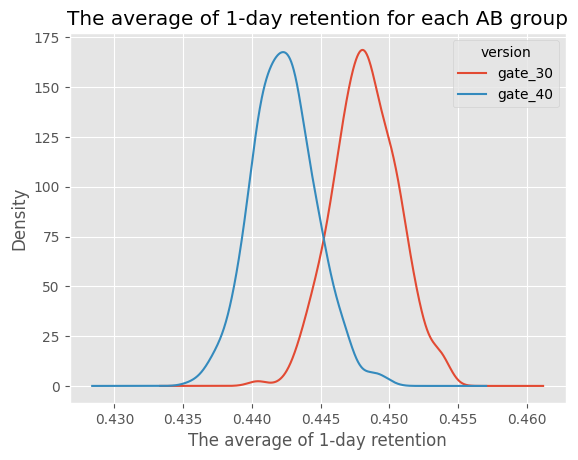

In [32]:
ax = boot_1d.plot.kde()
ax.set_title('The average of 1-day retention for each AB group')
ax.set_xlabel('The average of 1-day retention')

Увеличим разницу в удержании в течение 1 дня.

Text(0.5, 1.0, 'Zooming % difference')

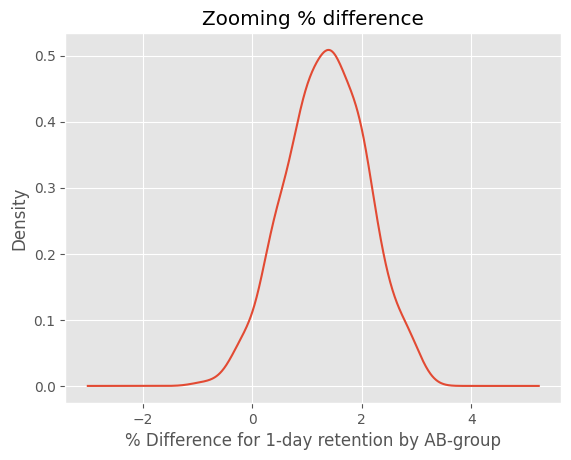

In [33]:
boot_1d['difference'] = (boot_1d['gate_30'] - boot_1d['gate_40']) / boot_1d['gate_40']*100

ax = boot_1d['difference'].plot.kde()
ax.set_xlabel('% Difference for 1-day retention by AB-group')
ax.set_title('Zooming % difference')

Из графика видно, что наиболее вероятная разница 1-2% в пользу ворот на 30 уровне.

Посчитаем в скольких процентах случаев разница больше 0.

In [34]:
prob = (boot_1d['difference'] > 0).sum() / len(boot_1d['difference'])
print(str(prob*100)+'%')

96.39999999999999%


Вывод:  
Существует высокая вероятность того, что удержание в течении 1 дня лучше, когда ворота находятся на уровне 30.

Дальше расчитаем удержание в течении 7 дней для двух AB групп.

In [35]:
df.groupby('version')['retention_7'].sum() / df.groupby('version')['retention_7'].count()

version
gate_30    0.190183
gate_40    0.182000
Name: retention_7, dtype: float64

Здесь так же процент удержания выше у gate_30.

Для более точного расчета воспользуемся bootstrap-анализом.

In [36]:
boot_7d = []
for i in range(500):
  boot_mean = df.retention_7.sample(frac=1, replace=True).groupby(df.version).mean()
  boot_7d.append(boot_mean)

boot_7d = pd.DataFrame(boot_7d)
print(boot_7d.head())

boot_7d['diff'] = (boot_7d['gate_30'] - boot_7d['gate_40']) / boot_7d['gate_40'] * 100

version       gate_30   gate_40
retention_7  0.190337  0.182555
retention_7  0.193060  0.180320
retention_7  0.189315  0.183887
retention_7  0.188408  0.186264
retention_7  0.187783  0.181810


1.0


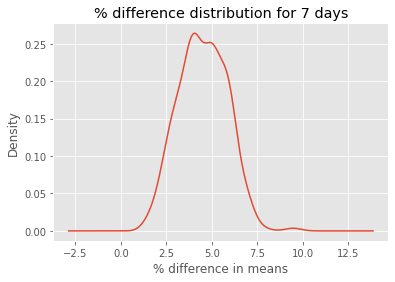

In [39]:
ax = boot_7d['diff'].plot.kde()
ax.set_xlabel('% difference in means')
ax.set_title('% difference distribution for 7 days')

prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])

print(prob)

In [37]:
prob = (boot_7d['diff'] > 0).sum() / len(boot_7d['diff'])
print(str(prob*100)+'%')

100.0%


Вывод:  
Удержание в течении 7 дней выше, когда ворота ноходятся на уровне 30. Следовательно для удержания аудитории не рекомендуется перемещать варота с 30 уровня на 40.